In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader

from src.moglow import Moglow
from src.data import DigitsDataset
from src.data import SeriesDataset

In [2]:
n_travels = 500
samples = np.random.choice(list(range(5050)), n_travels, replace=False)
df_train = (
    pd
    .read_csv('../data/raw/data-train.csv')
)
df_test = (
    pd
    .read_csv('../data/raw/data-test.csv')
)
df_train_sampled = df_train.query('travel in @samples')

In [3]:
train_set = SeriesDataset(
    df=df_train_sampled, 
    data_columns=['x1', 'x2'],
    label_column='label',
    serie_column='travel',
    seqlen=10,
    dropout=0
)

autoreg:(500, 290, 20)
self.x:(500, 2, 290)
self.cond:(500, 20, 290)


In [4]:
num_channels, seq_len = train_set[0]['x'].shape
cond_channels, _ = train_set[0]['cond'].shape
model = Moglow(
    num_channels=num_channels,
    cond_channels=cond_channels,
    seq_len=seq_len,
    levels=5,
    hidden_channels=128,
    network='ff'
)

In [5]:
loss = model.train(
    train_set,
    batch_size=128,
    max_epochs=300,
    log_interval=50,
    learning_rate=1e-3
)

 - Epoch  50: -931.688
 - Epoch 100: -1615.835
 - Epoch 150: -1577.384
 - Epoch 200: -1784.058
 - Epoch 250: -1873.521
 - Epoch 300: -2013.743


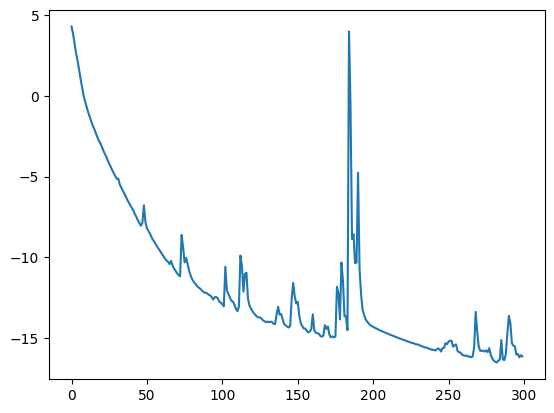

In [6]:
plt.plot(loss)
plt.show()

In [7]:
test_set = SeriesDataset(
    df=df_test, 
    data_columns=['x1', 'x2'],
    label_column='label',
    serie_column='travel',
    seqlen=10,
    dropout=0
)

autoreg:(5050, 290, 20)
self.x:(5050, 2, 290)
self.cond:(5050, 20, 290)


In [8]:
batch_size = 128
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
log_probs = []
for batch in train_loader:
    inputs = batch['x']
    conds = batch['cond']
    log_probs.append(-model.log_prob(inputs=inputs, conds=conds))

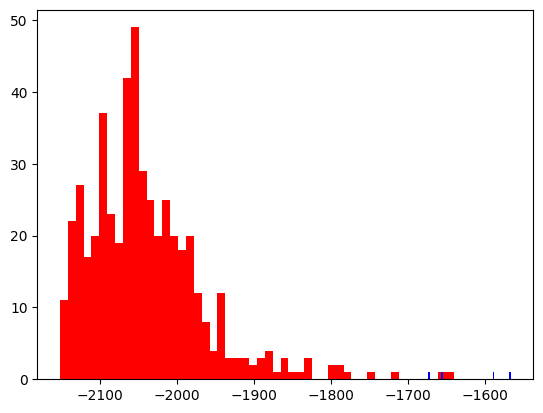

In [9]:
probs = torch.cat(log_probs).detach().numpy()

plt.hist(probs[train_set[:]['label'] == 0], bins=50, color='red')
plt.hist(probs[train_set[:]['label'] == 1], bins=50, color='blue')
plt.show()

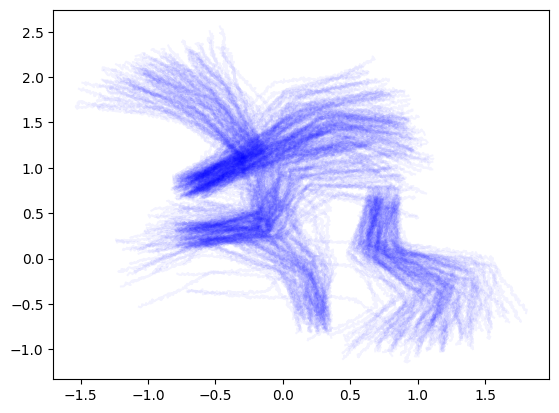

In [10]:
n_samples = 1
for travel in range(train_set[:]['cond'].shape[0]):
    conds = torch.Tensor(train_set[travel]['cond']).repeat(n_samples, 1, 1)
    samples, log_prob = model.sample(n_samples, conds)
    for sample in samples.detach().numpy():
        sample = sample.transpose()
        plt.plot(sample[:, 0], sample[:, 1], color='blue', alpha=.05)
plt.show()

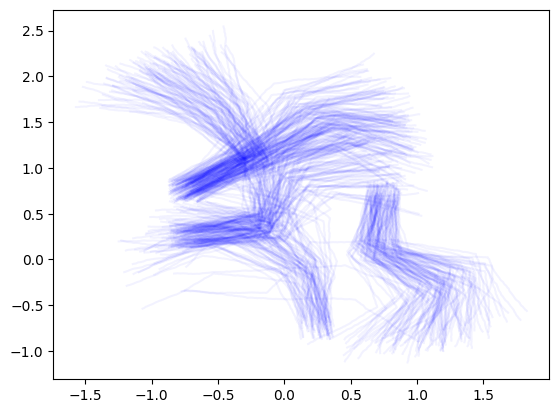

In [11]:
for travel in df_train_sampled.travel.unique():
    sample = df_train_sampled.query('travel == @travel')[['x1', 'x2']].values
    plt.plot(sample[:, 0], sample[:, 1], color='blue', alpha=.05)
plt.show()